In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [5]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [6]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='C:\\Users\\thuong\\tensorflow_datasets\\oxford_iiit_pet\\3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling

In [7]:
def visualize_data_distribution(dataset, dataset_name):
    num_cats = 0
    num_dogs = 0

    # Iterate over the dataset to count cats and dogs
    for example in dataset:
        species = example['species'].numpy()  # Assuming 'species' is a tensor
        if species == 0:  # 0 for cat
            num_cats += 1
        elif species == 1:  # 1 for dog
            num_dogs += 1

    # Plot the results
    labels = ['Cats', 'Dogs']
    counts = [num_cats, num_dogs]

    plt.figure(figsize=(8, 6))
    plt.bar(labels, counts, color=['red', 'blue'] if dataset_name == 'train' else ['yellow', 'blue'])
    plt.xlabel('Loài')
    plt.ylabel('Count')
    plt.title(f'Biểu đồ dữ liệu {dataset_name}')
    plt.show()

Số lượng hình ảnh của tập train: 3680


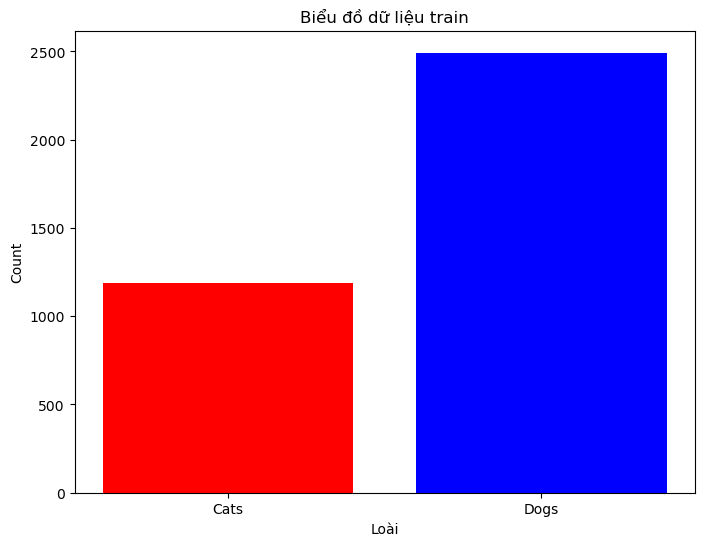

In [8]:
# Visualize the training data
train_ds = dataset['train']
print('Số lượng hình ảnh của tập train:', len(train_ds))
visualize_data_distribution(train_ds, 'train')

Số lượng hình ảnh của tập test: 3669


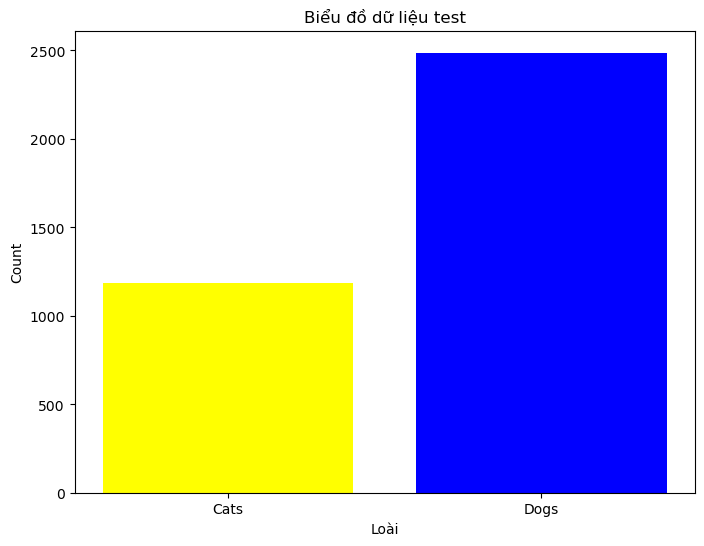

In [9]:
# Visualize the test data
test_ds = dataset['test']
print('Số lượng hình ảnh của tập test:', len(test_ds))
visualize_data_distribution(test_ds, 'test')

In [10]:
# Lấy thông tin về số lượng ảnh trong train và test
train_size = info.splits['train'].num_examples
test_size = info.splits['test'].num_examples

# Kiểm tra kích thước của một ảnh
image_shape = info.features['image'].shape

# Kiểm tra nếu image_shape có giá trị None, lấy giá trị từ ảnh mẫu
if None in image_shape:
    # Lấy một ảnh mẫu từ dataset để lấy kích thước
    sample_image = next(iter(dataset['train']))['image']
    image_shape = sample_image.shape

# Lấy chiều cao, chiều rộng và số kênh từ image_shape
image_height, image_width, num_channels = image_shape
bytes_per_pixel = 4  # Giả sử ảnh là float32, tức là mỗi pixel chiếm 4 bytes

# Tính bộ nhớ của một ảnh
memory_per_image_bytes = image_height * image_width * num_channels * bytes_per_pixel
memory_per_image_gb = memory_per_image_bytes / (1024 ** 3)  # Chuyển đổi sang GB

# Tính bộ nhớ tổng cho tập train và test
train_memory_gb = train_size * memory_per_image_gb
test_memory_gb = test_size * memory_per_image_gb

# In kết quả
print(f"Bộ nhớ của tập train: {train_memory_gb:.2f} GB")
print(f"Bộ nhớ của tập test: {test_memory_gb:.2f} GB")


Bộ nhớ của tập train: 10.28 GB
Bộ nhớ của tập test: 10.25 GB


In [12]:
#điều chỉnh kích thước hình ảnh về 128 128
def resize(input_image,input_mask):
    input_image = tf.image.resize(input_image,(128,128),method="nearest")

    input_mask = tf.image.resize(input_mask,(128,128),method = "nearest")

    return input_image,input_mask

In [16]:
# tăng cường dữ liệu bằng cách lật theo chiều ngang
def agument(input_image,input_mask):
    if tf.random.uniform(()) > 0.5:
        #lật ngẫu nhiên 
        input_image = tf.image.flip_left_right(input_image)
        
        input_mask = tf.image.flip_left_right(input_mask)
        
    return input_image,input_mask

In [13]:
#Chuẩn hóa dữ liệu chia hình ảnh nằm trong khoảng [-1,1] và đưa mặt nạ nhị phân về 1

In [18]:
def normalize(input_image,input_mask):
    input_image = tf.cast(input_image,tf.float32)/255.0
    input_mask -= 1
    return input_image,input_mask

In [19]:
#tiền xử lý dữ liệu trên tập huấn luyện 
def load_image_train(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    
    input_image,input_mask = resize(input_image,input_mask)
    input_image,input_mask = agument(input_image,input_mask)
    input_image,input_mask = normalize(input_image,input_mask)

    return input_image,input_mask

In [26]:
#tiền xử lý trên tập test 
def load_image_test(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]

    input_image,input_mask = resize(input_image,input_mask)
    input_image,input_mask = normalize(input_image,input_mask)

    return input_image,input_mask

In [28]:
#Xây dựng hàm để khởi tạo 
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test,num_parallel_calls=tf.data.AUTOTUNE)

In [30]:
Batch_size = 64
Buffer_size = 1000
train_batches = train_dataset.cache().shuffle(Buffer_size).batch(Batch_size).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

validation_bathches = test_dataset.take(3000).batch(Batch_size)
test_batches = test_dataset.skip(3000).take(669).batch(Batch_size)

In [32]:
def display(display_list):
 plt.figure(figsize=(15, 15))
 title = ["Input Image", "True Mask"]
 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()


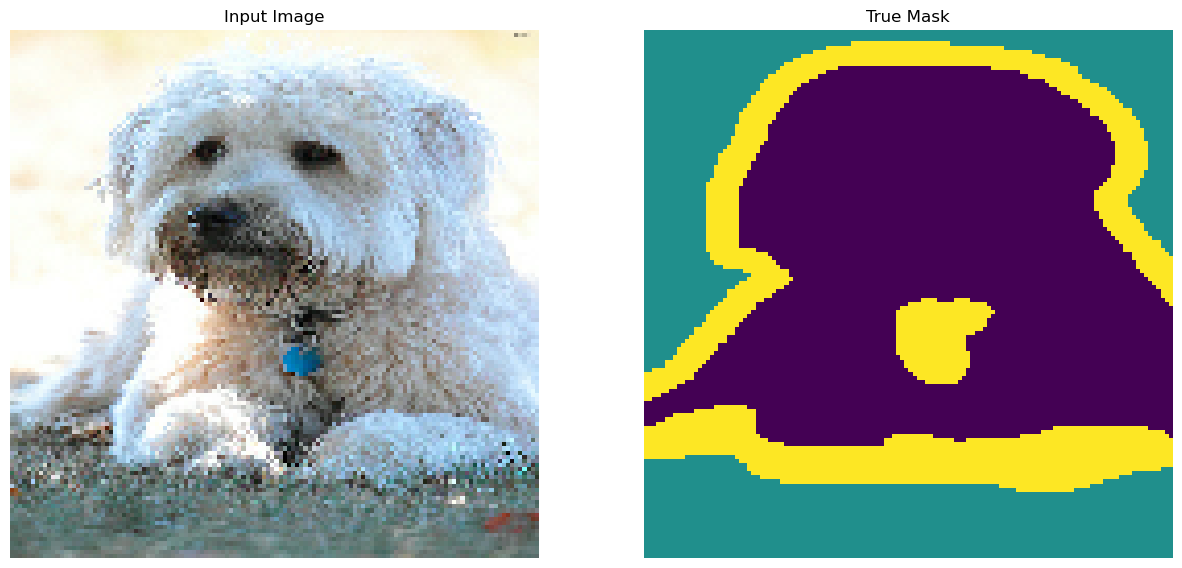

In [34]:
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [21]:
def double_conv_block(x,n_fillters): #x đầu vào cho khối tích chập, số lượng bộ lọc, 3 kích thước 

    #Conv2D then RELU activation
    x = layers.Conv2D(n_fillters, 3, padding = "same", activation= "relu", kernel_initializer="he_normal")(x)
    x = layers.Conv2D(n_fillters, 3, padding = "same", activation= "relu", kernel_initializer="he_normal")(x)
    return x

In [2]:
def downsample_block(x, n_fillters):
    f = double_conv_block(x,n_fillters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f,p

In [23]:
def upsample_block(x,conv_features, n_fillters):

    #upsample
    x = layers.Conv2DTranspose(n_fillters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x,conv_features])
    #dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x,n_fillters)

    return x

In [24]:
#inputs
def build_unet_model():
    inputs = layers.Input(shape=(128,128,3))
    
    # encoder: contracting path - downsample
    # 1 - downsample
    f1,p1 = downsample_block(inputs,64)
    
    # 2 - downsample
    f2,p2 = downsample_block(p1,128)
    
    # 3 - downsample
    f3,p3 = downsample_block(p2,256)
    
    f4,p4 = downsample_block(p3,512)
    
    # 5 - bottleneck
    bottleneck = double_conv_block(p4,1024)
    
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    
    # 7 - upsample
    u7 = upsample_block(u6,f3,256)
    
    # 8 - upsample
    u8 = upsample_block(u7,f2,128)
    
    # 9 - upsample
    u9 = upsample_block(u8,f1,64)
    
    outputs = layers.Conv2D(3, 1, padding="same", activation="softmax")(u9)
    
    u_net_model = tf.keras.Model(inputs,outputs,name="U-Net")
    return u_net_model

In [25]:
unet_model = build_unet_model()

In [26]:
NUM_EPOCHS = 20

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // Batch_size


VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // Batch_size // VAL_SUBSPLITS


In [27]:
# Compile the model
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_history = unet_model.fit(
    train_batches,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_batches,  # Sử dụng test_dataset làm validation
    validation_steps=VALIDATION_STEPS,
)


Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3157s 55s/step - accuracy: 0.5349 - loss: 1.1536 - val_accuracy: 0.5864 - val_loss: 0.8842
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3824s 68s/step - accuracy: 0.5846 - loss: 0.8627
Epoch 3/20


C:\Users\thuong\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


57/57 ━━━━━━━━━━━━━━━━━━━━ 4127s 72s/step - accuracy: 0.6467 - loss: 0.7676 - val_accuracy: 0.7201 - val_loss: 0.6741
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3894s 68s/step - accuracy: 0.7331 - loss: 0.6570
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3989s 70s/step - accuracy: 0.7561 - loss: 0.6036 - val_accuracy: 0.7673 - val_loss: 0.5695
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3802s 67s/step - accuracy: 0.7755 - loss: 0.5635
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3992s 70s/step - accuracy: 0.8005 - loss: 0.5075 - val_accuracy: 0.8261 - val_loss: 0.4459
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3893s 68s/step - accuracy: 0.8196 - loss: 0.4630
Epoch 9/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3977s 70s/step - accuracy: 0.8275 - loss: 0.4442 - val_accuracy: 0.8362 - val_loss: 0.4185
Epoch 10/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3800s 67s/step - accuracy: 0.8312 - loss: 0.4364
Epoch 11/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3985s 70s/step - accuracy: 0.8483 - loss: 0.3945 - val_accuracy: 0.8386 - val_loss: 0.4155
Epoch 12/20
57/5

In [69]:
# Lưu mô hình đã huấn luyện
unet_model.save('unet_model.keras')

In [36]:
from tensorflow.keras.models import load_model

# Tải mô hình đã huấn luyện
unet_model = load_model('unet_model.keras', compile=False)

In [38]:
# Hàm đánh giá Mean IoU (Jaccard Index)
def evaluate_jaccard_index(model, dataset, binary=True):
    jaccard_scores = []
    
    # Thiết lập `num_classes` dựa trên số lớp của `true_masks`
    for batch_data in dataset:
        input_images, true_masks = batch_data
        num_classes = 2 if binary else int(tf.reduce_max(true_masks)) + 1
        mean_iou_metric = tf.metrics.MeanIoU(num_classes=num_classes)

        true_masks = tf.cast(true_masks, dtype=tf.int32)  # MeanIoU yêu cầu nhãn là kiểu int

        # Dự đoán mặt nạ cho batch
        pred_masks = model.predict(input_images)
        
        if not binary:  # Phân đoạn đa lớp
            pred_masks = tf.argmax(pred_masks, axis=-1)
        else:  # Phân đoạn nhị phân
            pred_masks = tf.round(pred_masks)  # Làm tròn cho phân đoạn nhị phân
        
        pred_masks = tf.cast(pred_masks, dtype=tf.int32)  # Chuyển về kiểu int

        # Cập nhật giá trị cho metric MeanIoU
        mean_iou_metric.update_state(true_masks, pred_masks)
    
    # Lấy giá trị MeanIoU cuối cùng
    mean_jaccard = mean_iou_metric.result().numpy()
    mean_iou_metric.reset_state()  # Reset trạng thái metric cho lần đánh giá tiếp theo
    
    return mean_jaccard
# Đánh giá Mean IoU trên tập kiểm tra
mean_jaccard_test = evaluate_jaccard_index(unet_model, test_batches, binary=False)

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 8s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 8s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [39]:
print(f"Kết quả đánh giá: {mean_jaccard_test:.4f}")

Kết quả đánh giá: 0.7002


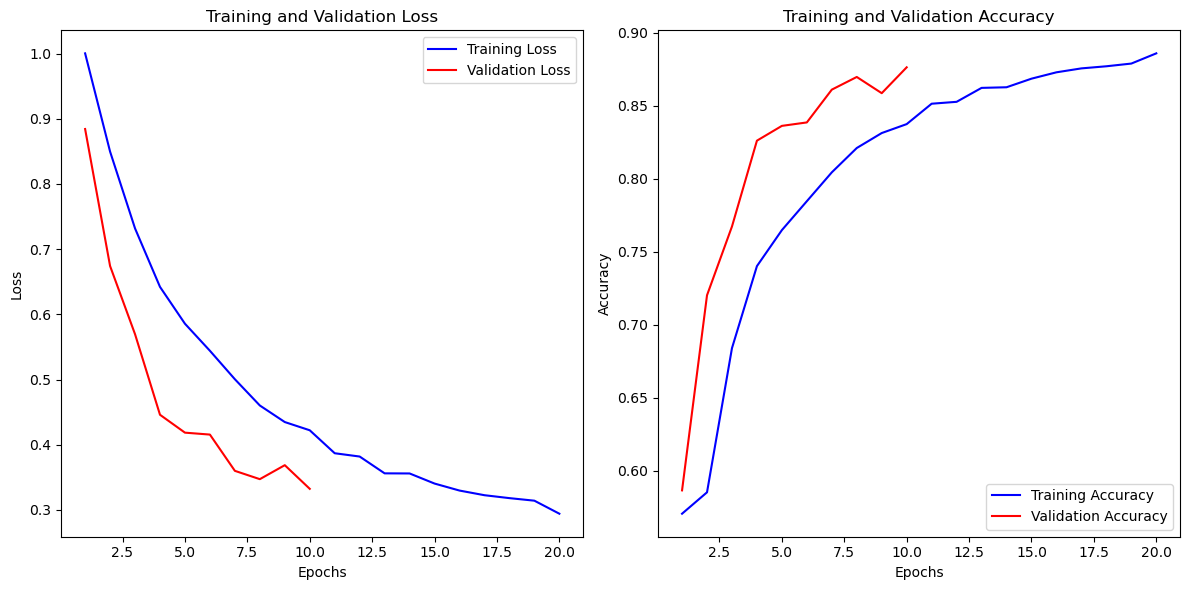

In [32]:
import matplotlib.pyplot as plt 
# not compute Mul as input #1(zero-based) was e

# Lấy giá trị loss và accuracy từ model_history
loss = model_history.history['loss']
val_loss = model_history.history.get('val_loss', [])  # Sử dụng .get để tránh lỗi nếu 'val_loss' không tồn tại

accuracy = model_history.history['accuracy']
val_accuracy = model_history.history.get('val_accuracy', [])

epochs = range(1, len(loss) + 1)
val_epochs = range(1, len(val_loss) + 1)  # Epochs cho validation nếu khác nhau

# Vẽ đồ thị Loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
if val_loss:  # Chỉ vẽ nếu có dữ liệu validation
    plt.plot(val_epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Vẽ đồ thị Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
if val_accuracy:  # Chỉ vẽ nếu có dữ liệu validation
    plt.plot(val_epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


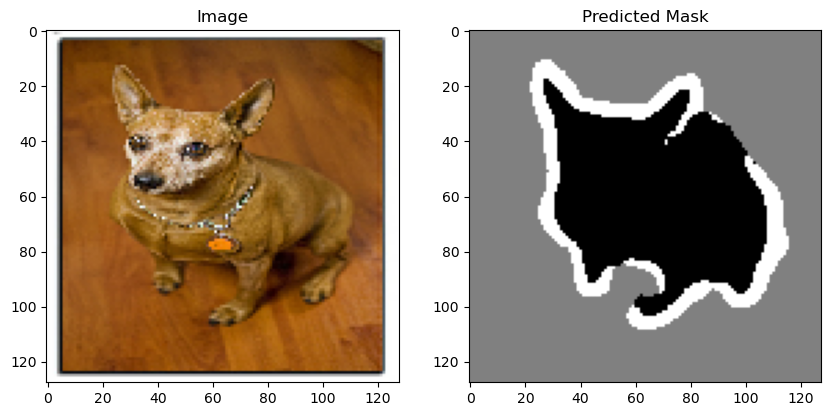

In [46]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Hàm hiển thị ảnh và mask dự đoán
def display_predictions(image, pred_mask):
    plt.figure(figsize=(10, 5))

    # Hiển thị ảnh gốc
    plt.subplot(1, 2, 1)
    plt.imshow(tf.squeeze(image))
    plt.title("Image")

    # Hiển thị mask dự đoán
    plt.subplot(1, 2, 2)
    plt.imshow(tf.argmax(pred_mask, axis=-1)[0], cmap='gray')
    plt.title("Predicted Mask")

    plt.show()

def show_test_predictions(test_batches, num=6):
    for images, _ in test_batches.take(1):  # Take one batch of images
        for i in range(num):
            # Select the ith image in the batch
            image = images[i]
            
            # Expand dimensions to simulate a batch of size 1
            image = tf.expand_dims(image, axis=0)
            
            # Generate prediction
            pred_mask = unet_model.predict(image)
            
            # Display the image and prediction
            display_predictions(tf.squeeze(image, axis=0), pred_mask)

# Hiển thị 6 ảnh từ tập test với mask dự đoán sau khi huấn luyện
show_test_predictions(test_batches, num=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


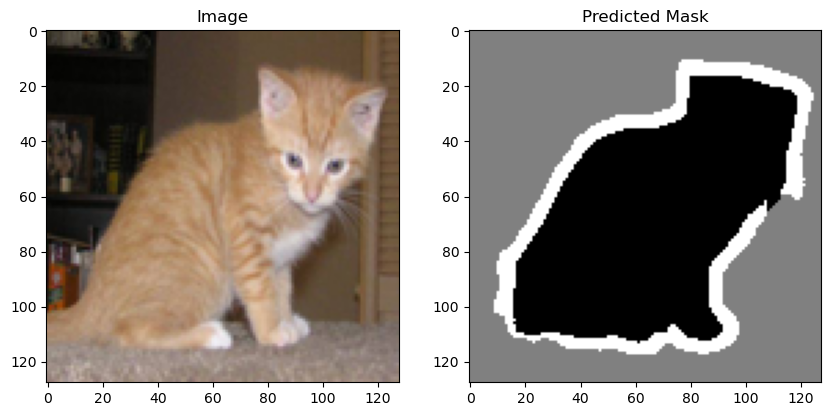

In [48]:
# Hàm hiển thị ảnh và mask dự đoán
def display_predictions(image, pred_mask):
    plt.figure(figsize=(10, 5))

    # Hiển thị ảnh gốc
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image")

    # Hiển thị mask dự đoán
    plt.subplot(1, 2, 2)
    plt.imshow(tf.argmax(pred_mask, axis=-1)[0], cmap='gray')
    plt.title("Predicted Mask")

    plt.show()

# Hàm dự đoán cho một ảnh đầu vào
def predict_image(image_path):
    # Đọc ảnh từ đường dẫn và tiền xử lý
    image = Image.open(image_path)
    image = image.resize((128, 128))  
    image = np.array(image) / 255.0  # Chuẩn hóa giá trị pixel 
    
    # Thêm chiều batch để có dạng (1, 128, 128, 3) cho đầu vào mô hình
    image = tf.expand_dims(image, axis=0)
    
    # Dự đoán mask phân vùng
    pred_mask = unet_model.predict(image)
    
    # Hiển thị ảnh và mask dự đoán
    display_predictions(image[0], pred_mask)

#  sử dụng hàm với một đường dẫn ảnh
image_path ="C:/Users/thuong/Pictures/Dog_Cat/dataset/test_set/cats/cat.4003.jpg"  
predict_image(image_path)
